In [60]:
import os
import random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

import json
from PIL import Image as PILImage
from torchvision.transforms import v2 as T
import torchvision
from matplotlib.patches import Rectangle

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [61]:
# Создание Dataset и Dataloader

class ParkingDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        """
        root_dir: путь до папки data
        split: 'train', 'valid' или 'test'
        transform: трансформации изображений и боксов
        """
        self.root_dir = os.path.join(root_dir, split)
        self.split = split
        self.transform = transform
        
        # Загружаем аннотации
        annotations_path = os.path.join(self.root_dir, '_annotations.coco.json')
        with open(annotations_path, 'r') as f:
            data = json.load(f)
        
        self.images = {img['id']: img for img in data['images']}
        self.annotations = {img_id: [] for img_id in self.images.keys()}
        
        self.categories = {cat['id']: cat['name'] for cat in data['categories']}
        self.category_ids = {cat['name']: cat['id'] for cat in data['categories']}
        
        for ann in data['annotations']:
            img_id = ann['image_id']
            if img_id in self.annotations:
                self.annotations[img_id].append(ann)
        
        self.samples = []
        for img_id, img_info in self.images.items():
            img_path = os.path.join(self.root_dir, img_info['file_name'])
            if os.path.exists(img_path):
                anns = self.annotations.get(img_id, [])
                self.samples.append((img_path, anns))
        
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, anns = self.samples[idx]
        
        # Загружаем изображение
        img = PILImage.open(img_path).convert('RGB')
        
        boxes = []
        labels = []
        
        for ann in anns:
            # COCO формат: [x_min, y_min, width, height]
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(ann['category_id'])
        
        # Конвертируем в тензоры
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        if len(boxes) > 0:
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([idx]),
                'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
            }
        else:
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
        
        if self.transform:
            img = self.transform(img)
        
        return img, target

def get_transform(split):

    if split == 'train':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    elif split == 'valid':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    else: 
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transform

def collate_fn(batch):
    # Для объединения батча с разным количеством объектов
    return tuple(zip(*batch))


train_transform = get_transform('train')
val_transform = get_transform('valid')
test_transform = get_transform('test')

# Создаем датасеты
# root = "data"
root = "data_mini"

train_dataset = ParkingDataset(root, split='train', transform=train_transform)
valid_dataset = ParkingDataset(root, split='valid', transform=val_transform)
test_dataset = ParkingDataset(root, split='test', transform=test_transform)

# Создаем даталодеры
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"\nКатегории: {train_dataset.categories}")
print()

# Выводим пример одного тензора из датасета
if len(train_dataset) > 0:
    img, target = train_dataset[0]
    
    print(f"Размер тензора: {img.shape}")
    

    for key, value in target.items():
        if torch.is_tensor(value):
            if len(value) > 0 and key in ['boxes', 'labels']:
                if key == 'boxes':
                    print(f"-Первые 2 бокса: {value[:2].tolist()}")
                elif key == 'labels':
                    labels_str = [f"{label.item()} ({train_dataset.categories.get(label.item(), 'unknown')})" 
                                 for label in value[:2]]
                    print(f"-Первые 2 метки: {labels_str}")
        #else:
            #print(f"  {key}: {value}")
    
    if 'boxes' in target and len(target['boxes']) > 0:
        print(f"\nКоличество объектов на изображении: {len(target['boxes'])}")
    else:
        print(f"\nНа изображении нет объектов")



Train dataset size: 754
Valid dataset size: 84
Test dataset size: 198

Категории: {0: 'spaces', 1: 'space-empty', 2: 'space-occupied'}

Размер тензора: torch.Size([3, 640, 640])
-Первые 2 бокса: [[304.0, 468.0, 387.5, 582.0], [271.0, 390.0, 347.5, 479.0]]
-Первые 2 метки: ['1 (space-empty)', '1 (space-empty)']

Количество объектов на изображении: 40


Перевод данный из формата COCO в YOLO

In [62]:
def coco_to_yolo_bbox(bbox, img_w, img_h):
    """
    bbox: [x_min, y_min, width, height] (COCO)
    return: [cx, cy, w, h] (YOLO, normalized)
    """
    x, y, w, h = bbox

    cx = x + w / 2.0
    cy = y + h / 2.0

    return [
        cx / img_w,
        cy / img_h,
        w / img_w,
        h / img_h
    ]



def convert_coco_to_yolo(
    root_dir,
    split="train",
    output_dir="yolo_dataset"
):
    """
    root_dir/
        train/
            images
            _annotations.coco.json
        valid/
        test/

    output_dir/
        images/train
        labels/train
    """

    split_dir = os.path.join(root_dir, split)
    ann_path = os.path.join(split_dir, "_annotations.coco.json")

    with open(ann_path, "r") as f:
        coco = json.load(f)

    # Создаём папки
    img_out_dir = os.path.join(output_dir, "images", split)
    lbl_out_dir = os.path.join(output_dir, "labels", split)
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(lbl_out_dir, exist_ok=True)

    # Индексация
    images = {img["id"]: img for img in coco["images"]}
    categories = {cat["id"]: idx for idx, cat in enumerate(coco["categories"])}

    annotations = {}
    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        annotations.setdefault(img_id, []).append(ann)

    # Конвертация
    for img_id, img_info in tqdm(images.items(), desc=f"Converting {split}"):
        file_name = img_info["file_name"]
        img_path = os.path.join(split_dir, file_name)

        if not os.path.exists(img_path):
            continue

        # Копируем изображение
        img = PILImage.open(img_path)
        img_w, img_h = img.size
        img.save(os.path.join(img_out_dir, file_name))

        label_path = os.path.join(
            lbl_out_dir,
            os.path.splitext(file_name)[0] + ".txt"
        )

        anns = annotations.get(img_id, [])

        with open(label_path, "w") as f:
            for ann in anns:
                if ann.get("iscrowd", 0) == 1:
                    continue

                yolo_bbox = coco_to_yolo_bbox(
                    ann["bbox"], img_w, img_h
                )

                class_id = categories[ann["category_id"]]

                line = f"{class_id} " + " ".join(
                    f"{x:.6f}" for x in yolo_bbox
                )
                f.write(line + "\n")

root = "data_mini"   # или data
out = "yolo_dataset"

for split in ["train", "valid", "test"]:
    convert_coco_to_yolo(root, split, out)


Converting test: 100%|██████████| 198/198 [00:00<00:00, 211.06it/s]


In [63]:
DATA_ROOT = "yolo_dataset"
TRAIN_IMAGES = os.path.join(DATA_ROOT, "images/train")
TRAIN_LABELS = os.path.join(DATA_ROOT, "labels/train")
VALID_IMAGES = os.path.join(DATA_ROOT, "images/valid")
VALID_LABELS = os.path.join(DATA_ROOT, "labels/valid")

print(f"Train images: {len(os.listdir(TRAIN_IMAGES))}")
print(f"Train labels: {len(os.listdir(TRAIN_LABELS))}")
print(f"Valid images: {len(os.listdir(VALID_IMAGES))}")
print(f"Valid labels: {len(os.listdir(VALID_LABELS))}")

sample_image = os.listdir(TRAIN_IMAGES)[0]
sample_label = sample_image.replace('.jpg', '.txt')
print(f"\nПример изображения: {sample_image}")
print(f"Пример аннотации: {sample_label}")

img_path = os.path.join(TRAIN_IMAGES, sample_image)
img = PILImage.open(img_path)
print(f"\nРазмер изображения: {img.size}")

label_path = os.path.join(TRAIN_LABELS, sample_label)
with open(label_path, 'r') as f:
    lines = f.readlines()
    print(f"\nКоличество объектов: {len(lines)}")
    print("Первые 3 аннотации:")
    for i, line in enumerate(lines[:3]):
        print(f"  {i+1}: {line.strip()}")


Train images: 754
Train labels: 754
Valid images: 84
Valid labels: 84

Пример изображения: train_000584.jpg
Пример аннотации: train_000584.txt

Размер изображения: (640, 640)

Количество объектов: 100
Первые 3 аннотации:
  1: 2 0.235156 0.289062 0.035937 0.062500
  2: 2 0.259766 0.291016 0.035156 0.066406
  3: 1 0.285547 0.291016 0.033594 0.066406


In [64]:
def parse_yolo_annotation(label_path, img_width, img_height):
    """
    Парсит YOLO аннотацию и возвращает боксы в абсолютных координатах

    """
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                center_x = float(parts[1]) * img_width
                center_y = float(parts[2]) * img_height
                width = float(parts[3]) * img_width
                height = float(parts[4]) * img_height
                
                x_min = center_x - width / 2
                y_min = center_y - height / 2
                x_max = center_x + width / 2
                y_max = center_y + height / 2
                
                boxes.append({
                    'class': class_id,
                    'x_center': center_x,
                    'y_center': center_y,
                    'width': width,
                    'height': height,
                    'x_min': x_min,
                    'y_min': y_min,
                    'x_max': x_max,
                    'y_max': y_max
                })
    return boxes

sample_boxes = parse_yolo_annotation(label_path, img.size[0], img.size[1])
print(f"Найдено {len(sample_boxes)} объектов")
print(sample_boxes[0])


Найдено 100 объектов
{'class': 2, 'x_center': 150.49984, 'y_center': 184.99967999999998, 'width': 22.999679999999998, 'height': 40.0, 'x_min': 139.0, 'y_min': 164.99967999999998, 'x_max': 161.99968, 'y_max': 204.99967999999998}


In [65]:
class ImprovedCraterDataset(Dataset):
    """
    Улучшенный датасет с правильной нормализацией ImageNet и аугментациями
    """
    
    def __init__(self, images_dir, labels_dir, img_size=416, grid_size=13, augment=False):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.img_size = img_size
        self.grid_size = grid_size
        self.augment = augment
        self.image_files = [f for f in os.listdir(images_dir) 
                           if f.endswith(('.jpg', '.png'))]
        
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
        
        if self.augment:
            self.augment_transform = transforms.Compose([
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            ])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        img = PILImage.open(img_path).convert('RGB')
        original_size = img.size
        
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.labels_dir, label_file)
        
        boxes = []
        if os.path.exists(label_path):
            boxes = parse_yolo_annotation(label_path, original_size[0], original_size[1])
        
        if self.augment and random.random() > 0.5:
            img = self.augment_transform(img)
        
        img = img.resize((self.img_size, self.img_size), PILImage.BILINEAR)
        
        img_tensor = transforms.ToTensor()(img)
        img_tensor = self.normalize(img_tensor)
        
        target = torch.zeros(5, self.grid_size, self.grid_size)
        
        scale_x = self.img_size / original_size[0]
        scale_y = self.img_size / original_size[1]
        
        for box in boxes:
            x_center = box['x_center'] * scale_x
            y_center = box['y_center'] * scale_y
            width = box['width'] * scale_x
            height = box['height'] * scale_y
            
            # Нормализация к [0, 1]
            x_norm = x_center / self.img_size
            y_norm = y_center / self.img_size
            w_norm = width / self.img_size
            h_norm = height / self.img_size
            
            # Определяем ячейку
            grid_x = int(x_norm * self.grid_size)
            grid_y = int(y_norm * self.grid_size)
            grid_x = max(0, min(self.grid_size - 1, grid_x))
            grid_y = max(0, min(self.grid_size - 1, grid_y))
            
            # Координаты относительно ячейки
            cell_x = (x_norm * self.grid_size) - grid_x
            cell_y = (y_norm * self.grid_size) - grid_y
            
            # Записываем в target
            if target[4, grid_y, grid_x] == 0:
                target[0, grid_y, grid_x] = cell_x
                target[1, grid_y, grid_x] = cell_y
                target[2, grid_y, grid_x] = w_norm
                target[3, grid_y, grid_x] = h_norm
                target[4, grid_y, grid_x] = 1.0
        
        return img_tensor, target


train_dataset_improved = ImprovedCraterDataset(
    TRAIN_IMAGES, TRAIN_LABELS, 
    img_size=640, grid_size=20, augment=True
)
valid_dataset_improved = ImprovedCraterDataset(
    VALID_IMAGES, VALID_LABELS, 
    img_size=640, grid_size=20, augment=False
)

sample_img, sample_target = train_dataset_improved[0]
print(f"  Image: {sample_img.shape}")
print(f"  Target: {sample_target.shape}")


  Image: torch.Size([3, 640, 640])
  Target: torch.Size([5, 20, 20])


Метрики:

In [66]:
def compute_iou_loss(pred_boxes, target_boxes, eps=1e-6):
    """
    Вычисляет IoU loss для лучшей локализации
    
    Args:
        pred_boxes: (N, 4) - [x, y, w, h] нормализованные
        target_boxes: (N, 4) - [x, y, w, h] нормализованные
    
    Returns:
        iou_loss: скаляр
    """
    pred_x1 = pred_boxes[:, 0] - pred_boxes[:, 2] / 2
    pred_y1 = pred_boxes[:, 1] - pred_boxes[:, 3] / 2
    pred_x2 = pred_boxes[:, 0] + pred_boxes[:, 2] / 2
    pred_y2 = pred_boxes[:, 1] + pred_boxes[:, 3] / 2
    
    target_x1 = target_boxes[:, 0] - target_boxes[:, 2] / 2
    target_y1 = target_boxes[:, 1] - target_boxes[:, 3] / 2
    target_x2 = target_boxes[:, 0] + target_boxes[:, 2] / 2
    target_y2 = target_boxes[:, 1] + target_boxes[:, 3] / 2
    
    # Площадь пересечения
    inter_x1 = torch.max(pred_x1, target_x1)
    inter_y1 = torch.max(pred_y1, target_y1)
    inter_x2 = torch.min(pred_x2, target_x2)
    inter_y2 = torch.min(pred_y2, target_y2)
    
    inter_w = (inter_x2 - inter_x1).clamp(min=0)
    inter_h = (inter_y2 - inter_y1).clamp(min=0)
    inter_area = inter_w * inter_h
    
    # Площадь объединения
    pred_area = pred_boxes[:, 2] * pred_boxes[:, 3]
    target_area = target_boxes[:, 2] * target_boxes[:, 3]
    union_area = pred_area + target_area - inter_area
    
    # IoU
    iou = inter_area / (union_area + eps)
    
    # IoU loss = 1 - IoU
    iou_loss = 1 - iou
    
    return iou_loss.mean()


def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal Loss для objectness - борется с дисбалансом классов
    
    Args:
        pred: (N,) - предсказания после sigmoid [0, 1]
        target: (N,) - целевые значения {0, 1}
        alpha: вес для положительных примеров
        gamma: фокусирующий параметр
    
    Returns:
        loss: скаляр
    """
    bce = F.binary_cross_entropy(pred, target, reduction='none')
    
    # Focal weight
    p_t = pred * target + (1 - pred) * (1 - target)
    focal_weight = (1 - p_t) ** gamma
    
    # Alpha weight
    alpha_t = alpha * target + (1 - alpha) * (1 - target)
    
    loss = alpha_t * focal_weight * bce
    
    return loss.mean()


def improved_detection_loss(pred, target, lambda_coord=5.0, lambda_iou=2.0, lambda_noobj=0.5):
    """
    Улучшенная функция потерь с IoU loss и Focal loss

    """
    obj_mask = target[:, 4, :, :] > 0
    noobj_mask = target[:, 4, :, :] == 0
    
    # Применяем активации
    pred_xy = torch.sigmoid(pred[:, 0:2, :, :])
    pred_wh = torch.sigmoid(pred[:, 2:4, :, :])  # sigmoid вместо exp для стабильности
    pred_conf = torch.sigmoid(pred[:, 4:5, :, :])
    
    coord_loss = torch.tensor(0.0).to(pred.device)
    if obj_mask.sum() > 0:
        # XY loss
        xy_loss = F.mse_loss(
            pred_xy.permute(0, 2, 3, 1)[obj_mask],
            target[:, 0:2, :, :].permute(0, 2, 3, 1)[obj_mask],
            reduction='mean'
        )
        
        # WH loss
        wh_loss = F.mse_loss(
            pred_wh.permute(0, 2, 3, 1)[obj_mask],
            target[:, 2:4, :, :].permute(0, 2, 3, 1)[obj_mask],
            reduction='mean'
        )
        
        coord_loss = lambda_coord * (xy_loss + wh_loss)
    
    iou_loss_val = torch.tensor(0.0).to(pred.device)
    if obj_mask.sum() > 0:
        # Собираем боксы с объектами
        pred_boxes_obj = torch.cat([
            pred_xy.permute(0, 2, 3, 1)[obj_mask],
            pred_wh.permute(0, 2, 3, 1)[obj_mask]
        ], dim=1)
        
        target_boxes_obj = torch.cat([
            target[:, 0:2, :, :].permute(0, 2, 3, 1)[obj_mask],
            target[:, 2:4, :, :].permute(0, 2, 3, 1)[obj_mask]
        ], dim=1)
        
        iou_loss_val = lambda_iou * compute_iou_loss(pred_boxes_obj, target_boxes_obj)
    
    obj_loss = torch.tensor(0.0).to(pred.device)
    if obj_mask.sum() > 0:
        obj_loss = focal_loss(
            pred_conf[:, 0, :, :][obj_mask],
            target[:, 4, :, :][obj_mask],
            alpha=0.75,
            gamma=2.0
        )
    
    noobj_loss = torch.tensor(0.0).to(pred.device)
    if noobj_mask.sum() > 0:
        noobj_loss = lambda_noobj * F.binary_cross_entropy(
            pred_conf[:, 0, :, :][noobj_mask],
            target[:, 4, :, :][noobj_mask],
            reduction='mean'
        )
    
    total_loss = coord_loss + iou_loss_val + obj_loss + noobj_loss
    
    return total_loss, coord_loss, iou_loss_val, obj_loss, noobj_loss

dummy_pred = torch.randn(2, 5, 20, 20)
dummy_target = torch.zeros(2, 5, 20, 20)
dummy_target[0, :, 5, 5] = torch.tensor([0.5, 0.5, 0.2, 0.2, 1.0])
dummy_target[1, :, 8, 3] = torch.tensor([0.3, 0.7, 0.15, 0.15, 1.0])

loss, coord, iou_l, obj, noobj = improved_detection_loss(dummy_pred, dummy_target)
print(f" Total: {loss.item():.4f}")
print(f"  Coord: {coord.item():.4f}")
print(f"  IoU: {iou_l.item():.4f}")
print(f"  Obj: {obj.item():.4f}")
print(f"  NoObj: {noobj.item():.4f}")


 Total: 3.5799
  Coord: 1.1185
  IoU: 1.9315
  Obj: 0.1343
  NoObj: 0.3957


Кастомная модель YOLO v2 с предобученным ResNet18 backbone

Используем размер изображений 640х640 и сетику 20х20

In [67]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights

class CraterDetectorResNet(nn.Module):
    """
    Кастомная модель детекции с предобученным ResNet18 backbone
    """
    
    def __init__(self, pretrained=True):
        super(CraterDetectorResNet, self).__init__()
        
        # Загружаем предобученный ResNet18
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            resnet = models.resnet18(weights=weights)
        else:
            resnet = models.resnet18(weights=None)
        
        # Извлекаем слои backbone (до avgpool)
        self.conv1 = resnet.conv1        # 3 -> 64, stride=2
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool    # stride=2
        
        self.layer1 = resnet.layer1      # 64 -> 64
        self.layer2 = resnet.layer2      # 64 -> 128, stride=2
        self.layer3 = resnet.layer3      # 128 -> 256, stride=2
        self.layer4 = resnet.layer4      # 256 -> 512, stride=2
        
        # После всех слоев: 640 -> 320 -> 160 -> 80 -> 40 -> 20
        
        # Подготовщик фичей
        self.refine = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        
        # Голова
        self.detect = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(64, 5, kernel_size=1),  # x, y, w, h, conf
        )
        
        for m in self.refine.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        
        for m in self.detect.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)      # -> (B, 64, 320, 320)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)    # -> (B, 64, 160, 160)
        
        x = self.layer1(x)     # -> (B, 64, 160, 160)
        x = self.layer2(x)     # -> (B, 128, 80, 80)
        x = self.layer3(x)     # -> (B, 256, 40, 40)
        x = self.layer4(x)     # -> (B, 512, 20, 20)
        
        x = self.refine(x)     # -> (B, 128, 20, 20)
        
        x = self.detect(x)     # -> (B, 5, 20, 20)
        
        return x


resnet_model = CraterDetectorResNet(pretrained=True)
print(f"Параметров: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Обучаемых параметров: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")

dummy_input = torch.randn(2, 3, 640, 640)
with torch.no_grad():
    dummy_output = resnet_model(dummy_input)
    
print(f"\nВход: {dummy_input.shape}")
print(f"Выход: {dummy_output.shape}")



Параметров: 12,726,469
Обучаемых параметров: 12,726,469

Вход: torch.Size([2, 3, 640, 640])
Выход: torch.Size([2, 5, 20, 20])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

batch_size = 8
train_loader_resnet = DataLoader(
    train_dataset_improved, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
valid_loader_resnet = DataLoader(
    valid_dataset_improved, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

resnet_model_20 = CraterDetectorResNet(pretrained=True).to(device)

backbone_params = []
for name, param in resnet_model.named_parameters():
    if 'conv1' in name or 'bn1' in name or 'layer' in name:
        backbone_params.append(param)

# Head (новые слои) - больший LR
head_params = []
for name, param in resnet_model.named_parameters():
    if 'refine' in name or 'detect' in name:
        head_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4},   # Маленький LR для backbone
    {'params': head_params, 'lr': 1e-3}        # Больший LR для head
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

num_epochs = 10



Device: cpu



In [ ]:
history_resnet = {
    'train_loss': [],
    'valid_loss': [],
    'lr': []
}

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    resnet_model_20.train()
    epoch_losses = {'total': 0, 'coord': 0, 'iou': 0, 'obj': 0, 'noobj': 0}
    
    pbar = tqdm(train_loader_resnet, desc=f"Эпоха {epoch+1}/{num_epochs}")
    for batch_idx, (images, targets) in enumerate(pbar):
        images = images.to(device)
        targets = targets.to(device)
        
        outputs = resnet_model(images)
        loss, coord_l, iou_l, obj_l, noobj_l = improved_detection_loss(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(resnet_model.parameters(), max_norm=10.0)
        
        optimizer.step()
        
        epoch_losses['total'] += loss.item()
        epoch_losses['coord'] += coord_l.item()
        
        pbar.set_postfix({
            'loss': f"{loss.item():.3f}",
        })
    
    avg_train_loss = epoch_losses['total'] / len(train_loader_resnet)
    
    history_resnet['train_loss'].append(avg_train_loss)
    history_resnet['lr'].append(optimizer.param_groups[0]['lr'])
    
    resnet_model.eval()
    valid_loss = 0
    valid_coord = 0
    valid_iou = 0
    
    with torch.no_grad():
        for images, targets in valid_loader_resnet:
            images = images.to(device)
            targets = targets.to(device)
            outputs = resnet_model(images)
            loss, coord_l, iou_l, _, _ = improved_detection_loss(outputs, targets)
            valid_loss += loss.item()
    
    avg_valid_loss = valid_loss / len(valid_loader_resnet)
    
    history_resnet['valid_loss'].append(avg_valid_loss)
    
    scheduler.step()
    
    # Выводим результаты
    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Valid Loss: {avg_valid_loss:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f} (backbone) / {optimizer.param_groups[1]['lr']:.6f} (head)")
    
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': resnet_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'valid_loss': avg_valid_loss,
        }, 'best_resnet_20.pth')
    else:
        print()


Эпоха 1/10: 100%|██████████| 95/95 [07:38<00:00,  4.82s/it, loss=2.201]


Эпоха 1/10:
  Train Loss: 2.5125
  Valid Loss: 2.1818
  LR: 0.000098 (backbone) / 0.000976 (head)


Эпоха 2/10: 100%|██████████| 95/95 [07:49<00:00,  4.94s/it, loss=2.038]


Эпоха 2/10:
  Train Loss: 2.0782
  Valid Loss: 1.9118
  LR: 0.000091 (backbone) / 0.000905 (head)


Эпоха 3/10: 100%|██████████| 95/95 [07:49<00:00,  4.94s/it, loss=1.984]


Эпоха 3/10:
  Train Loss: 1.9075
  Valid Loss: 1.7764
  LR: 0.000080 (backbone) / 0.000794 (head)


Эпоха 4/10: 100%|██████████| 95/95 [12:17<00:00,  7.76s/it, loss=1.712]


Эпоха 4/10:
  Train Loss: 1.7879
  Valid Loss: 1.6979
  LR: 0.000066 (backbone) / 0.000655 (head)


Эпоха 5/10: 100%|██████████| 95/95 [12:16<00:00,  7.75s/it, loss=1.856]


Эпоха 5/10:
  Train Loss: 1.7312
  Valid Loss: 1.5805
  LR: 0.000051 (backbone) / 0.000501 (head)


Эпоха 6/10: 100%|██████████| 95/95 [11:27<00:00,  7.23s/it, loss=1.648]


Эпоха 6/10:
  Train Loss: 1.6659
  Valid Loss: 1.6189
  LR: 0.000035 (backbone) / 0.000346 (head)



Эпоха 7/10: 100%|██████████| 95/95 [12:15<00:00,  7.75s/it, loss=1.788]


Эпоха 7/10:
  Train Loss: 1.6034
  Valid Loss: 1.3873
  LR: 0.000021 (backbone) / 0.000207 (head)


Эпоха 8/10: 100%|██████████| 95/95 [10:43<00:00,  6.77s/it, loss=1.380]


Эпоха 8/10:
  Train Loss: 1.5535
  Valid Loss: 1.3968
  LR: 0.000010 (backbone) / 0.000096 (head)



Эпоха 9/10: 100%|██████████| 95/95 [11:40<00:00,  7.38s/it, loss=1.012]


Эпоха 9/10:
  Train Loss: 1.5202
  Valid Loss: 1.3503
  LR: 0.000003 (backbone) / 0.000025 (head)


Эпоха 10/10: 100%|██████████| 95/95 [08:14<00:00,  5.21s/it, loss=1.311]


Эпоха 10/10:
  Train Loss: 1.5154
  Valid Loss: 1.3194
  LR: 0.000100 (backbone) / 0.001000 (head)


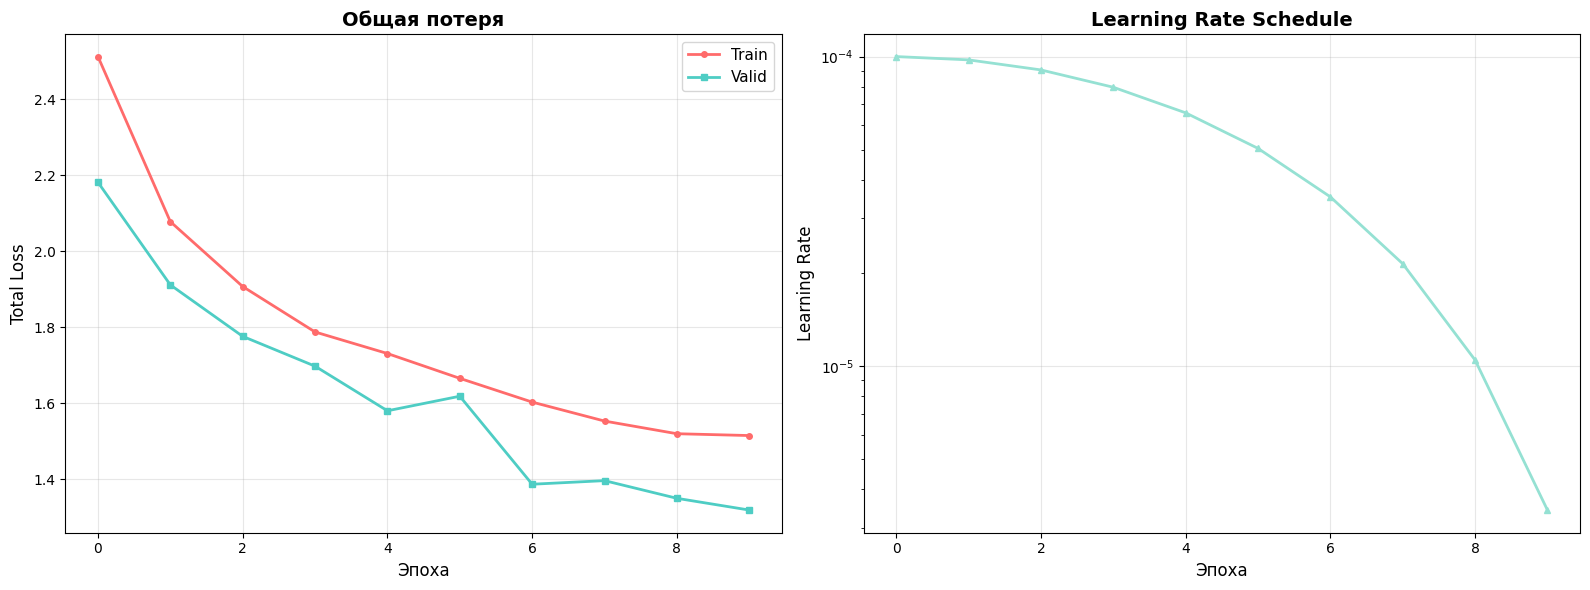

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

axes[0].plot(history_resnet['train_loss'], label='Train', marker='o', linewidth=2, markersize=4, color='#FF6B6B')
axes[0].plot(history_resnet['valid_loss'], label='Valid', marker='s', linewidth=2, markersize=4, color='#4ECDC4')
axes[0].set_xlabel('Эпоха', fontsize=12)
axes[0].set_ylabel('Total Loss', fontsize=12)
axes[0].set_title('Общая потеря', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_resnet['lr'], marker='^', linewidth=2, color='#95E1D3', markersize=4)
axes[1].set_xlabel('Эпоха', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [71]:
def decode_resnet_predictions(output, img_size=416, grid_size=13, conf_threshold=0.5):
    """
    Декодирует выход ResNet модели (с sigmoid активациями для wh)
    """
    batch_size = output.shape[0]
    boxes = []
    
    pred_xy = torch.sigmoid(output[:, 0:2, :, :])
    pred_wh = torch.sigmoid(output[:, 2:4, :, :])  # sigmoid!
    pred_conf = torch.sigmoid(output[:, 4:5, :, :])
    
    cell_size = img_size / grid_size
    
    for b in range(batch_size):
        for i in range(grid_size):
            for j in range(grid_size):
                conf = pred_conf[b, 0, i, j].item()
                
                if conf > conf_threshold:
                    # Координаты относительно ячейки
                    x_cell = pred_xy[b, 0, i, j].item()
                    y_cell = pred_xy[b, 1, i, j].item()
                    
                    # Нормализованные размеры
                    w_norm = pred_wh[b, 0, i, j].item()
                    h_norm = pred_wh[b, 1, i, j].item()
                    
                    # Абсолютные координаты
                    x_center = (j + x_cell) * cell_size
                    y_center = (i + y_cell) * cell_size
                    width = w_norm * img_size
                    height = h_norm * img_size
                    
                    # Формат (x_min, y_min, x_max, y_max)
                    x_min = x_center - width / 2
                    y_min = y_center - height / 2
                    x_max = x_center + width / 2
                    y_max = y_center + height / 2
                    
                    boxes.append((x_min, y_min, x_max, y_max, conf))
    
    return boxes


In [72]:
def calculate_iou(box1, box2):
    """
    Вычисляет Intersection over Union (IoU) между двумя боксами

    """
    x1_min, y1_min, x1_max, y1_max = box1[:4]
    x2_min, y2_min, x2_max, y2_max = box2[:4]
    
    # Вычисляем площадь пересечения
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)
    
    if inter_x_max <= inter_x_min or inter_y_max <= inter_y_min:
        return 0.0
    
    inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    
    # Вычисляем площадь объединения
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area
    
    if union_area == 0:
        return 0.0
    
    iou = inter_area / union_area
    return iou

box1 = (10, 10, 50, 50)
box2 = (30, 30, 70, 70)  # Перекрывается с box1
box3 = (100, 100, 150, 150)  # Не перекрывается

print(f"IoU(box1, box2) = {calculate_iou(box1, box2):.3f}")
print(f"IoU(box1, box3) = {calculate_iou(box1, box3):.3f}")


IoU(box1, box2) = 0.143
IoU(box1, box3) = 0.000


In [73]:
def non_max_suppression(boxes, iou_threshold=0.5, conf_threshold=0.5):
    """
    Применяет Non-Maximum Suppression к списку боксо
    """
    # Фильтруем по уверенности
    filtered = [box for box in boxes if box[4] >= conf_threshold]
    
    if len(filtered) == 0:
        return []
    
    # Сортируем по уверенности (убывание)
    filtered.sort(key=lambda x: x[4], reverse=True)
    
    # Применяем NMS
    keep = []
    while len(filtered) > 0:
        # Берем бокс с наибольшей уверенностью
        current = filtered.pop(0)
        keep.append(current)
        
        # Удаляем все боксы, которые сильно перекрываются с текущим
        filtered = [
            box for box in filtered
            if calculate_iou(current[:4], box[:4]) < iou_threshold
        ]
    
    return keep

/var/folders/jq/_zy15fcx77lg7dyhsljnkfch0000gn/T/ipykernel_51982/2859879954.py:90: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


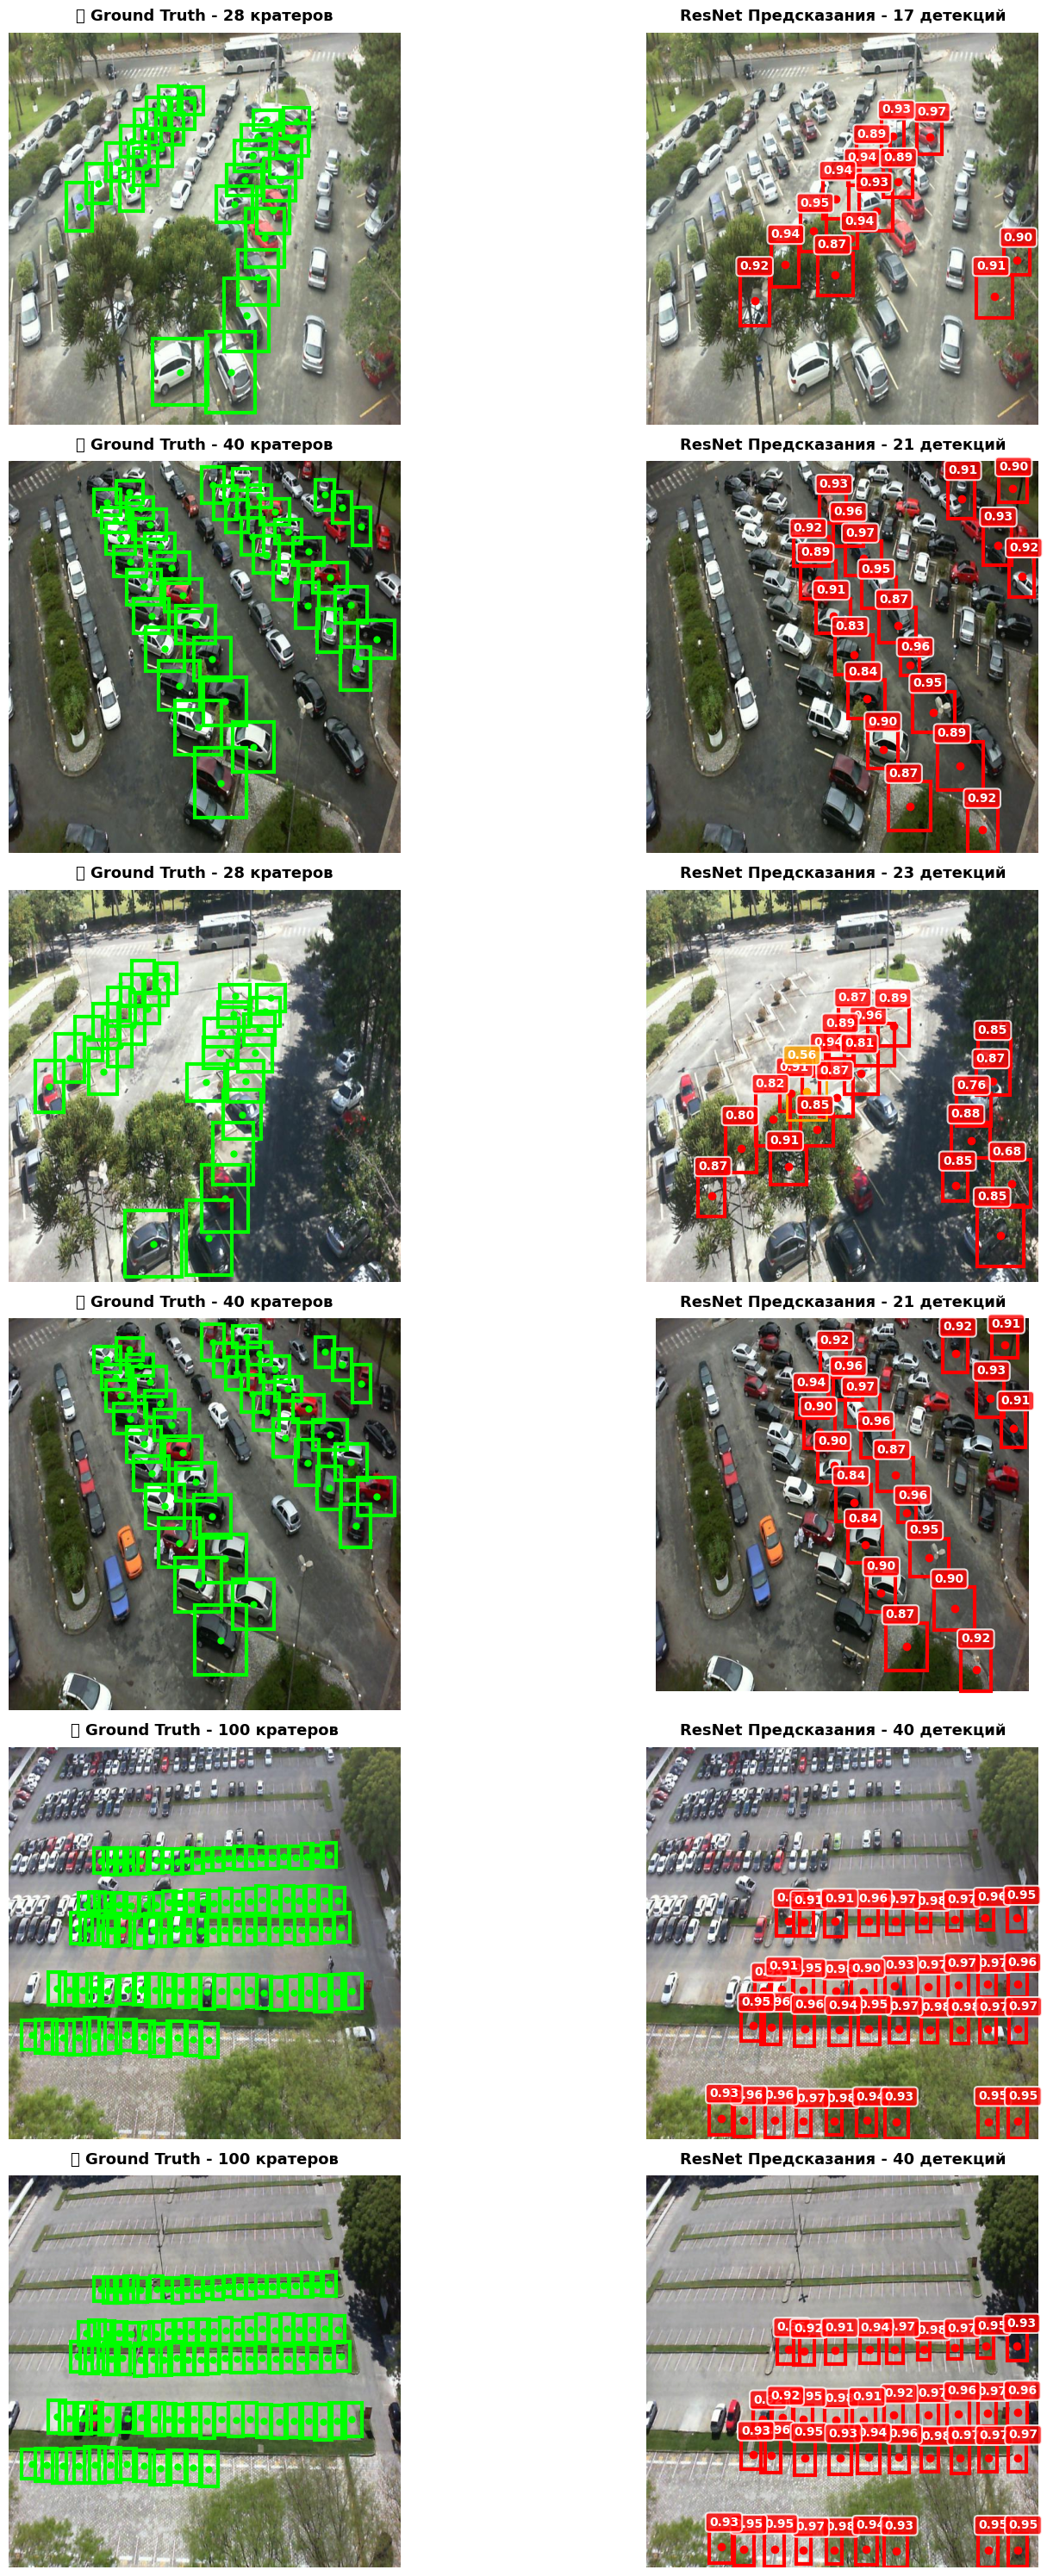

In [ ]:
resnet_model_20.eval()

num_samples = 6
sample_indices = random.sample(range(len(valid_dataset_improved)), num_samples)

fig, axes = plt.subplots(num_samples, 2, figsize=(18, 5*num_samples))

for idx, sample_idx in enumerate(sample_indices):
    img_file = valid_dataset_improved.image_files[sample_idx]
    img_path = os.path.join(VALID_IMAGES, img_file)
    label_path = os.path.join(VALID_LABELS, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
    
    img = PILImage.open(img_path).convert('RGB')
    original_size = img.size
    
    img_tensor, _ = valid_dataset_improved[sample_idx]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = resnet_model(img_tensor)
    
    pred_boxes = decode_resnet_predictions(output.cpu(), conf_threshold=0.3)
    
    nms_boxes = non_max_suppression(pred_boxes, iou_threshold=0.4, conf_threshold=0.3)
    
    # Загружаем ground truth
    gt_boxes = []
    if os.path.exists(label_path):
        gt_boxes = parse_yolo_annotation(label_path, original_size[0], original_size[1])
    
    # Масштабируем предсказания
    scale_x = original_size[0] / 416
    scale_y = original_size[1] / 416
    
    # === Ground Truth ===
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"🎯 Ground Truth - {len(gt_boxes)} кратеров", 
                          fontsize=13, fontweight='bold', pad=10)
    axes[idx, 0].axis('off')
    
    for box in gt_boxes:
        rect = Rectangle((box['x_min'], box['y_min']), box['width'], box['height'],
                        linewidth=3, edgecolor='lime', facecolor='none', linestyle='-')
        axes[idx, 0].add_patch(rect)
        # Добавляем точку в центре
        cx = box['x_min'] + box['width']/2
        cy = box['y_min'] + box['height']/2
        axes[idx, 0].plot(cx, cy, 'o', color='lime', markersize=5)
    
    # === Предсказания ===
    axes[idx, 1].imshow(img)
    axes[idx, 1].set_title(f"ResNet Предсказания - {len(nms_boxes)} детекций", 
                          fontsize=13, fontweight='bold', pad=10)
    axes[idx, 1].axis('off')
    
    # Сортируем по confidence
    nms_boxes_sorted = sorted(nms_boxes, key=lambda x: x[4], reverse=True)
    
    for x_min, y_min, x_max, y_max, conf in nms_boxes_sorted:
        x_min_s = max(0, x_min * scale_x)
        y_min_s = max(0, y_min * scale_y)
        w_s = (x_max - x_min) * scale_x
        h_s = (y_max - y_min) * scale_y
        
        # Проверяем валидность
        if w_s > 0 and h_s > 0 and x_min_s + w_s <= original_size[0] and y_min_s + h_s <= original_size[1]:
            # Цвет зависит от confidence
            if conf > 0.6:
                color = 'red'
                lw = 3
            elif conf > 0.4:
                color = 'orange'
                lw = 2
            else:
                color = 'yellow'
                lw = 2
            
            rect = Rectangle((x_min_s, y_min_s), w_s, h_s,
                            linewidth=lw, edgecolor=color, facecolor='none')
            axes[idx, 1].add_patch(rect)
            
            axes[idx, 1].text(x_min_s, y_min_s - 8, f"{conf:.2f}", 
                            color='white', fontsize=10, weight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8, edgecolor='white', linewidth=1.5))
            
            cx = x_min_s + w_s/2
            cy = y_min_s + h_s/2
            axes[idx, 1].plot(cx, cy, 'o', color=color, markersize=6)

plt.tight_layout()
plt.show()


Кастомная модель YOLO v2 с предобученным ResNet18 backbone

Используем размер изображений 416х416 и сетику 13х13

In [75]:
train_dataset_improved = ImprovedCraterDataset(
    TRAIN_IMAGES, TRAIN_LABELS, 
    img_size=416, grid_size=13, augment=True
)
valid_dataset_improved = ImprovedCraterDataset(
    VALID_IMAGES, VALID_LABELS, 
    img_size=416, grid_size=13, augment=False
)

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}\n")

batch_size = 8
train_loader_resnet = DataLoader(
    train_dataset_improved, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
valid_loader_resnet = DataLoader(
    valid_dataset_improved, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

resnet_model_13 = CraterDetectorResNet(pretrained=True).to(device)

backbone_params = []
for name, param in resnet_model.named_parameters():
    if 'conv1' in name or 'bn1' in name or 'layer' in name:
        backbone_params.append(param)

# Head (новые слои) - больший LR
head_params = []
for name, param in resnet_model.named_parameters():
    if 'refine' in name or 'detect' in name:
        head_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': 1e-4},   # Маленький LR для backbone
    {'params': head_params, 'lr': 1e-3}        # Больший LR для head
], weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

num_epochs = 10



Device: cpu



In [77]:
history_resnet = {
    'train_loss': [],
    'valid_loss': [],
    'lr': []
}

best_valid_loss = float('inf')

for epoch in range(num_epochs):
    resnet_model.train()
    epoch_losses = {'total': 0, 'coord': 0, 'iou': 0, 'obj': 0, 'noobj': 0}
    
    pbar = tqdm(train_loader_resnet, desc=f"Эпоха {epoch+1}/{num_epochs}")
    for batch_idx, (images, targets) in enumerate(pbar):
        images = images.to(device)
        targets = targets.to(device)
        
        outputs = resnet_model(images)
        loss, coord_l, iou_l, obj_l, noobj_l = improved_detection_loss(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping для стабильности
        torch.nn.utils.clip_grad_norm_(resnet_model.parameters(), max_norm=10.0)
        
        optimizer.step()
        
        epoch_losses['total'] += loss.item()
        epoch_losses['coord'] += coord_l.item()
        
        pbar.set_postfix({
            'loss': f"{loss.item():.3f}",
        })
    
    avg_train_loss = epoch_losses['total'] / len(train_loader_resnet)
    
    history_resnet['train_loss'].append(avg_train_loss)
    history_resnet['lr'].append(optimizer.param_groups[0]['lr'])
    
    resnet_model.eval()
    valid_loss = 0
    valid_coord = 0
    valid_iou = 0
    
    with torch.no_grad():
        for images, targets in valid_loader_resnet:
            images = images.to(device)
            targets = targets.to(device)
            outputs = resnet_model(images)
            loss, coord_l, iou_l, _, _ = improved_detection_loss(outputs, targets)
            valid_loss += loss.item()
    
    avg_valid_loss = valid_loss / len(valid_loader_resnet)
    
    history_resnet['valid_loss'].append(avg_valid_loss)
    
    scheduler.step()
    
    # Выводим результаты
    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Valid Loss: {avg_valid_loss:.4f}")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f} (backbone) / {optimizer.param_groups[1]['lr']:.6f} (head)")
    
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': resnet_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'valid_loss': avg_valid_loss,
        }, 'best_resnet_13.pth')
    else:
        print()


Эпоха 1/10: 100%|██████████| 95/95 [03:10<00:00,  2.01s/it, loss=1.872]


Эпоха 1/10:
  Train Loss: 2.0726
  Valid Loss: 1.8004
  LR: 0.000098 (backbone) / 0.000976 (head)


Эпоха 2/10: 100%|██████████| 95/95 [03:08<00:00,  1.99s/it, loss=1.676]


Эпоха 2/10:
  Train Loss: 1.7105
  Valid Loss: 1.5041
  LR: 0.000091 (backbone) / 0.000905 (head)


Эпоха 3/10: 100%|██████████| 95/95 [03:20<00:00,  2.11s/it, loss=1.609]


Эпоха 3/10:
  Train Loss: 1.5632
  Valid Loss: 1.2831
  LR: 0.000080 (backbone) / 0.000794 (head)


Эпоха 4/10: 100%|██████████| 95/95 [03:33<00:00,  2.25s/it, loss=1.389]


Эпоха 4/10:
  Train Loss: 1.4479
  Valid Loss: 1.1668
  LR: 0.000066 (backbone) / 0.000655 (head)


Эпоха 5/10: 100%|██████████| 95/95 [02:31<00:00,  1.60s/it, loss=1.083]


Эпоха 5/10:
  Train Loss: 1.3411
  Valid Loss: 1.0242
  LR: 0.000051 (backbone) / 0.000501 (head)


Эпоха 6/10: 100%|██████████| 95/95 [02:14<00:00,  1.41s/it, loss=1.275]


Эпоха 6/10:
  Train Loss: 1.2893
  Valid Loss: 0.9677
  LR: 0.000035 (backbone) / 0.000346 (head)


Эпоха 7/10: 100%|██████████| 95/95 [02:15<00:00,  1.42s/it, loss=1.099]


Эпоха 7/10:
  Train Loss: 1.2390
  Valid Loss: 0.9216
  LR: 0.000021 (backbone) / 0.000207 (head)


Эпоха 8/10: 100%|██████████| 95/95 [02:15<00:00,  1.43s/it, loss=1.350]


Эпоха 8/10:
  Train Loss: 1.1957
  Valid Loss: 0.8753
  LR: 0.000010 (backbone) / 0.000096 (head)


Эпоха 9/10: 100%|██████████| 95/95 [02:15<00:00,  1.43s/it, loss=1.141]


Эпоха 9/10:
  Train Loss: 1.1694
  Valid Loss: 0.8957
  LR: 0.000003 (backbone) / 0.000025 (head)



Эпоха 10/10: 100%|██████████| 95/95 [02:15<00:00,  1.43s/it, loss=1.050]


Эпоха 10/10:
  Train Loss: 1.1480
  Valid Loss: 0.8937
  LR: 0.000100 (backbone) / 0.001000 (head)



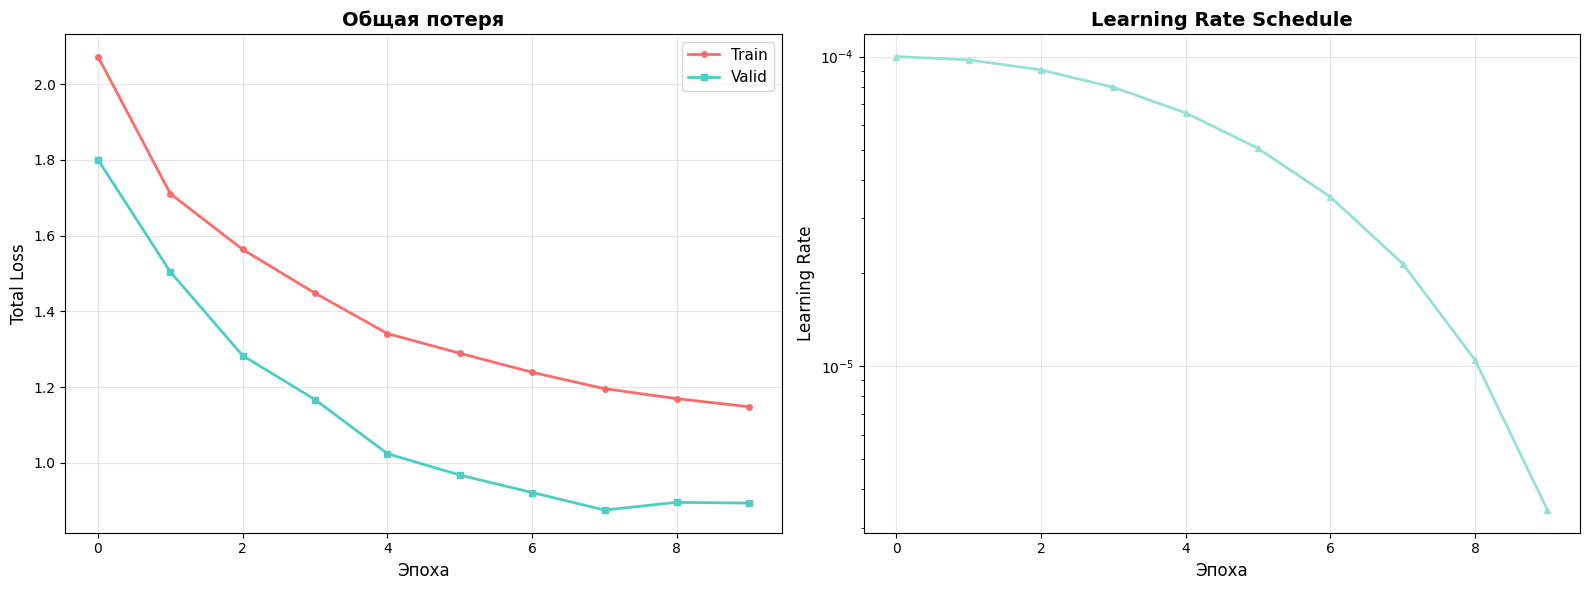

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

axes[0].plot(history_resnet['train_loss'], label='Train', marker='o', linewidth=2, markersize=4, color='#FF6B6B')
axes[0].plot(history_resnet['valid_loss'], label='Valid', marker='s', linewidth=2, markersize=4, color='#4ECDC4')
axes[0].set_xlabel('Эпоха', fontsize=12)
axes[0].set_ylabel('Total Loss', fontsize=12)
axes[0].set_title('Общая потеря', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_resnet['lr'], marker='^', linewidth=2, color='#95E1D3', markersize=4)
axes[1].set_xlabel('Эпоха', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


/var/folders/jq/_zy15fcx77lg7dyhsljnkfch0000gn/T/ipykernel_51982/1548552840.py:90: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


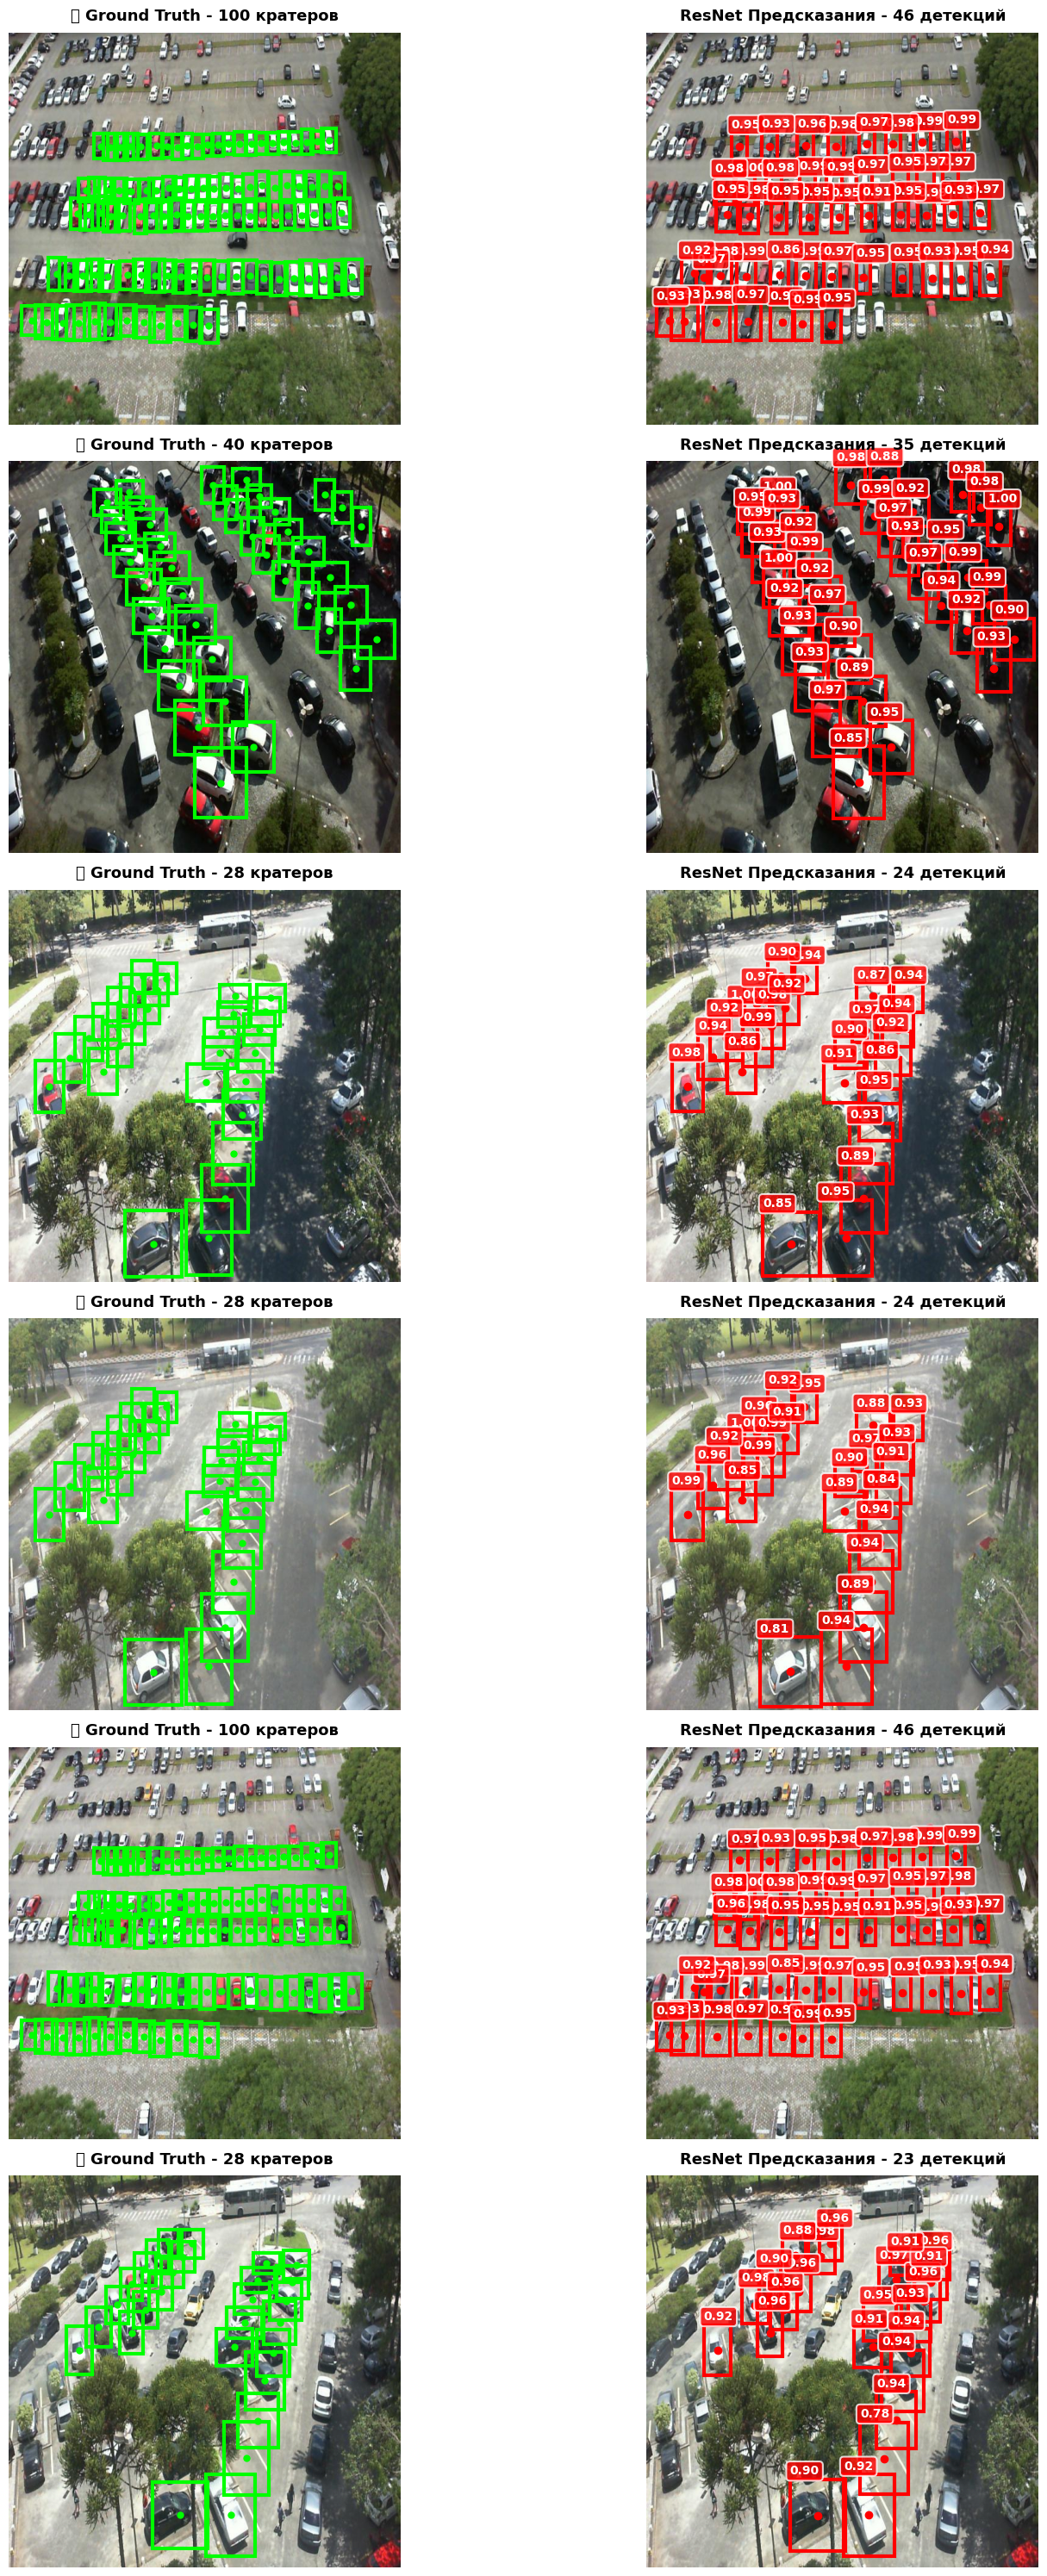

In [79]:
resnet_model_13.eval()

num_samples = 6
sample_indices = random.sample(range(len(valid_dataset_improved)), num_samples)

fig, axes = plt.subplots(num_samples, 2, figsize=(18, 5*num_samples))

for idx, sample_idx in enumerate(sample_indices):
    img_file = valid_dataset_improved.image_files[sample_idx]
    img_path = os.path.join(VALID_IMAGES, img_file)
    label_path = os.path.join(VALID_LABELS, img_file.replace('.jpg', '.txt').replace('.png', '.txt'))
    
    img = PILImage.open(img_path).convert('RGB')
    original_size = img.size
    
    img_tensor, _ = valid_dataset_improved[sample_idx]
    img_tensor = img_tensor.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = resnet_model(img_tensor)
    
    pred_boxes = decode_resnet_predictions(output.cpu(), conf_threshold=0.3)
    
    nms_boxes = non_max_suppression(pred_boxes, iou_threshold=0.4, conf_threshold=0.3)
    
    # Загружаем ground truth
    gt_boxes = []
    if os.path.exists(label_path):
        gt_boxes = parse_yolo_annotation(label_path, original_size[0], original_size[1])
    
    # Масштабируем предсказания
    scale_x = original_size[0] / 416
    scale_y = original_size[1] / 416
    
    # === Ground Truth ===
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"🎯 Ground Truth - {len(gt_boxes)} кратеров", 
                          fontsize=13, fontweight='bold', pad=10)
    axes[idx, 0].axis('off')
    
    for box in gt_boxes:
        rect = Rectangle((box['x_min'], box['y_min']), box['width'], box['height'],
                        linewidth=3, edgecolor='lime', facecolor='none', linestyle='-')
        axes[idx, 0].add_patch(rect)
        # Добавляем точку в центре
        cx = box['x_min'] + box['width']/2
        cy = box['y_min'] + box['height']/2
        axes[idx, 0].plot(cx, cy, 'o', color='lime', markersize=5)
    
    # === Предсказания ===
    axes[idx, 1].imshow(img)
    axes[idx, 1].set_title(f"ResNet Предсказания - {len(nms_boxes)} детекций", 
                          fontsize=13, fontweight='bold', pad=10)
    axes[idx, 1].axis('off')
    
    # Сортируем по confidence
    nms_boxes_sorted = sorted(nms_boxes, key=lambda x: x[4], reverse=True)
    
    for x_min, y_min, x_max, y_max, conf in nms_boxes_sorted:
        x_min_s = max(0, x_min * scale_x)
        y_min_s = max(0, y_min * scale_y)
        w_s = (x_max - x_min) * scale_x
        h_s = (y_max - y_min) * scale_y
        
        # Проверяем валидность
        if w_s > 0 and h_s > 0 and x_min_s + w_s <= original_size[0] and y_min_s + h_s <= original_size[1]:
            # Цвет зависит от confidence
            if conf > 0.6:
                color = 'red'
                lw = 3
            elif conf > 0.4:
                color = 'orange'
                lw = 2
            else:
                color = 'yellow'
                lw = 2
            
            rect = Rectangle((x_min_s, y_min_s), w_s, h_s,
                            linewidth=lw, edgecolor=color, facecolor='none')
            axes[idx, 1].add_patch(rect)
            
            axes[idx, 1].text(x_min_s, y_min_s - 8, f"{conf:.2f}", 
                            color='white', fontsize=10, weight='bold',
                            bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.8, edgecolor='white', linewidth=1.5))
            
            cx = x_min_s + w_s/2
            cy = y_min_s + h_s/2
            axes[idx, 1].plot(cx, cy, 'o', color=color, markersize=6)

plt.tight_layout()
plt.show()
